In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import re
from collections import Counter

In [40]:
sc.set_figure_params(dpi=100, color_map = 'viridis')
sc.settings.verbosity = 1

In [123]:
def extract_cell_stage(row):
    """Extracts simplified cell stage information from metadata."""
    def _extract_preimplantation_blastomere(row):
        xcell = re.match('(\d\-cell).+', row.source_name)
        morulae = re.match('(Morulae).+', row.source_name)
        blast = re.match('(Late blastocyst).+', row.source_name)
        if xcell:
            return xcell.group(1)
        elif morulae:
            return morulae.group(1)
        elif blast:
            return blast.group(1)
    
    def _extract_hESC(row):
        match row.source_name:
            case 'hESC passage#0':
                return 'hESC early'
            case 'hESC passage#10':
                return 'hESC late'
            case 'cDNAs of individual cell of human embryonic stem cells':
                return 'hESC early'

    cell_name = 'NA'
    match row.cell_type:
        case 'human preimplantation blastomere (Oocyte)':
            cell_name = 'Oocyte'
        case 'human preimplantation blastomere (zygote)':
            cell_name = 'Zygote'
        case 'human preimplantation blastomere (2-cell)':
            cell_name = '2-cell'
        case 'human preimplantation blastomere':
            cell_name = _extract_preimplantation_blastomere(row)
        case 'human embryonic stem cell':
            cell_name = _extract_hESC(row)
    
    return cell_name

metadata_df = pd.read_csv('../data/expression/SraRunTable.txt')
metadata_df['cell_stage'] = pd.Categorical(metadata_df.apply(extract_cell_stage, axis=1), 
                                          ['Oocyte', 'Zygote', '2-cell', '4-cell', '8-cell', 'Morulae', 'Late blastocyst', 'hESC early', 'hESC late'])
metadata_df = metadata_df.sort_values('cell_stage').reset_index(drop=True)
metadata_df.head()

Run Assay Type  AvgSpotLen       Bases   BioProject     BioSample  \
0  SRR445718    RNA-Seq         100  3294366500  PRJNA153427  SAMN00828830   
1  SRR445719    RNA-Seq         100  3069082500  PRJNA153427  SAMN00828831   
2  SRR445720    RNA-Seq         100  2555287600  PRJNA153427  SAMN00828832   
3  SRR445721    RNA-Seq         100  3652834700  PRJNA153427  SAMN00828833   
4  SRR445722    RNA-Seq         100  3286531500  PRJNA153427  SAMN00828834   

        Bytes                                  cell_type Center Name Consent  \
0  2230497119  human preimplantation blastomere (Oocyte)         GEO  public   
1  2073552136  human preimplantation blastomere (Oocyte)         GEO  public   
2  1730162973  human preimplantation blastomere (Oocyte)         GEO  public   
3  2265323784  human preimplantation blastomere (zygote)         GEO  public   
4  2041709355  human preimplantation blastomere (zygote)         GEO  public   

   ...      Organism  Platform           ReleaseDate Sample Name  \
0  ...  Homo sapiens  ILLUMINA  2013-08-12T00:00:00Z   GSM896803   
1  ...  Homo sapiens  ILLUMINA  2013-08-12T00:00:00Z   GSM896804   
2  ...  Homo sapiens  ILLUMINA  2013-08-12T00:00:00Z   GSM896805   
3  ...  Homo sapiens  ILLUMINA  2013-08-12T00:00:00Z   GSM896806   
4  ...  Homo sapiens  ILLUMINA  2013-08-12T00:00:00Z   GSM896807   

                                         source_name  SRA Study  \
0  cDNAs of individual cells of preimplantation e...  SRP011546   
1  cDNAs of individual cells of preimplantation e...  SRP011546   
2  cDNAs of individual cells of preimplantation e...  SRP011546   
3  cDNAs of individual cells of preimplantation e...  SRP011546   
4  cDNAs of individual cells of preimplantation e...  SRP011546   

                          tissue           create_date version cell_stage  
0  human preimplantation embryos  2012-08-11T22:16:00Z     2.0     Oocyte  
1  human preimplantation embryos  2012-08-11T22:16:00Z     2.0     Oocyte  
2  human preimplantation embryos  2012-08-11T22:15:00Z     2.0     Oocyte  
3  human preimplantation embryos  2012-08-11T22:16:00Z     2.0     Zygote  
4  human preimplantation embryos  2012-08-11T22:15:00Z     2.0     Zygote  

[5 rows x 31 columns]

In [124]:
set(metadata_df.source_name)

{'4-cell embryo#1',
 '4-cell embryo#2',
 '4-cell embryo#3',
 '8-cell embryo#1',
 '8-cell embryo#2',
 '8-cell embryo#3',
 'Late blastocyst #1',
 'Late blastocyst #2',
 'Late blastocyst #3',
 'Morulae #1',
 'Morulae #2',
 'cDNAs of individual cell of human embryonic stem cells',
 'cDNAs of individual cells of preimplantation embryos',
 'hESC passage#0',
 'hESC passage#10'}

In [125]:
counts = []
c = 0
for row in metadata_df.iterrows():
    with open(f'../data/expression/TEcount-out/{row[1].Run}.cntTable') as input:
        input.readline()
        if c == 0:
            data = [line.strip().split('\t') for line in input]
            genes = [i[0].strip('"') for i in data]  
            data = [int(i[1]) for i in data]
        else:
            data = [int(line.strip().split('\t')[1]) for line in input]
        counts.append(data)
    c += 1

counts_ad = ad.AnnData(np.array(counts), dtype=np.int32)
counts_ad.obs['run'] = pd.Categorical(metadata_df.Run)
counts_ad.obs['cell_stage'] = pd.Categorical(metadata_df.cell_stage, ordered=True)
counts_ad.obs['source_name'] = pd.Categorical(metadata_df.source_name)
counts_ad.var_names = genes

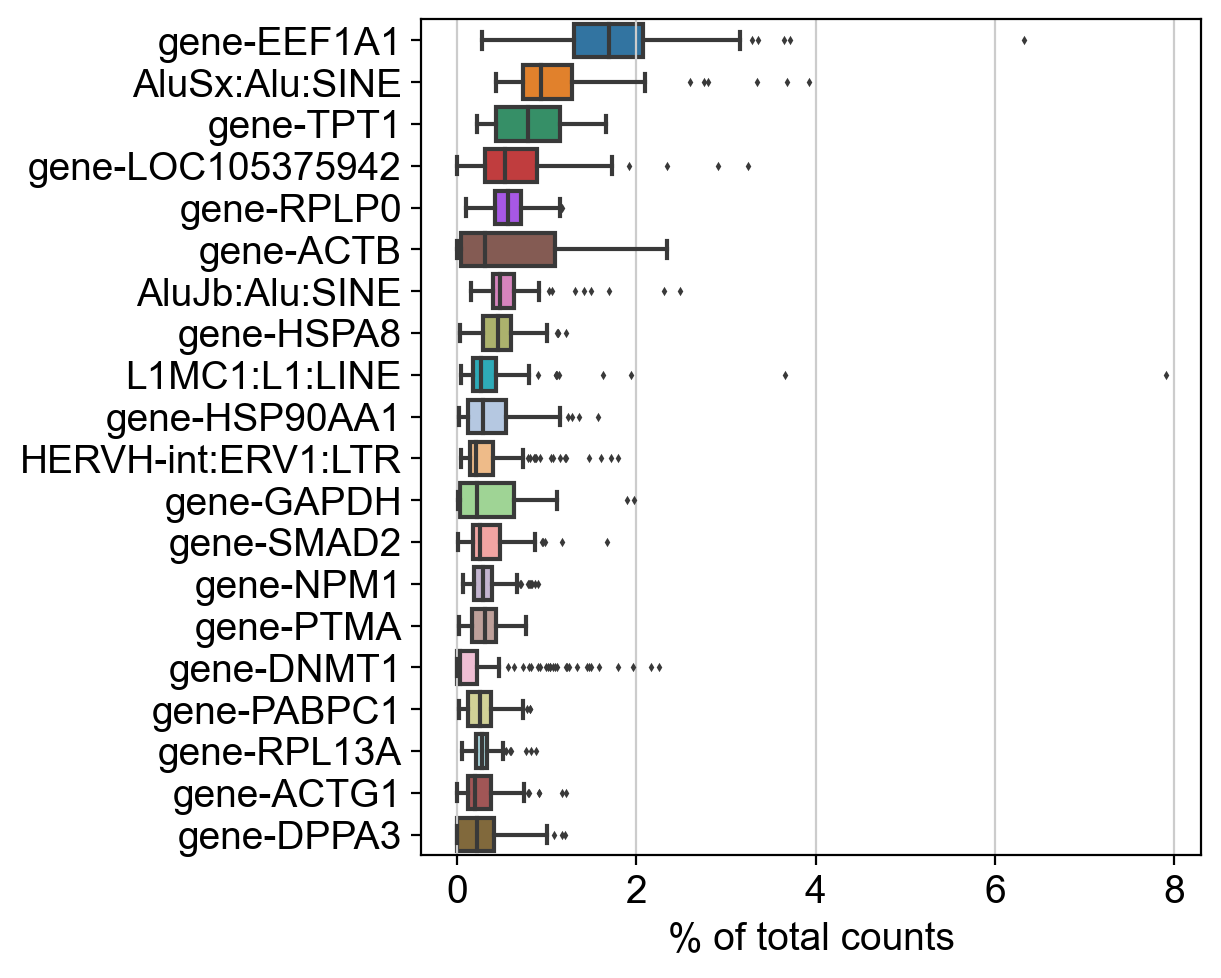

In [126]:
sc.pl.highest_expr_genes(counts_ad, n_top=20, )

In [127]:
sc.pp.calculate_qc_metrics(counts_ad, percent_top=None, log1p=False, inplace=True)

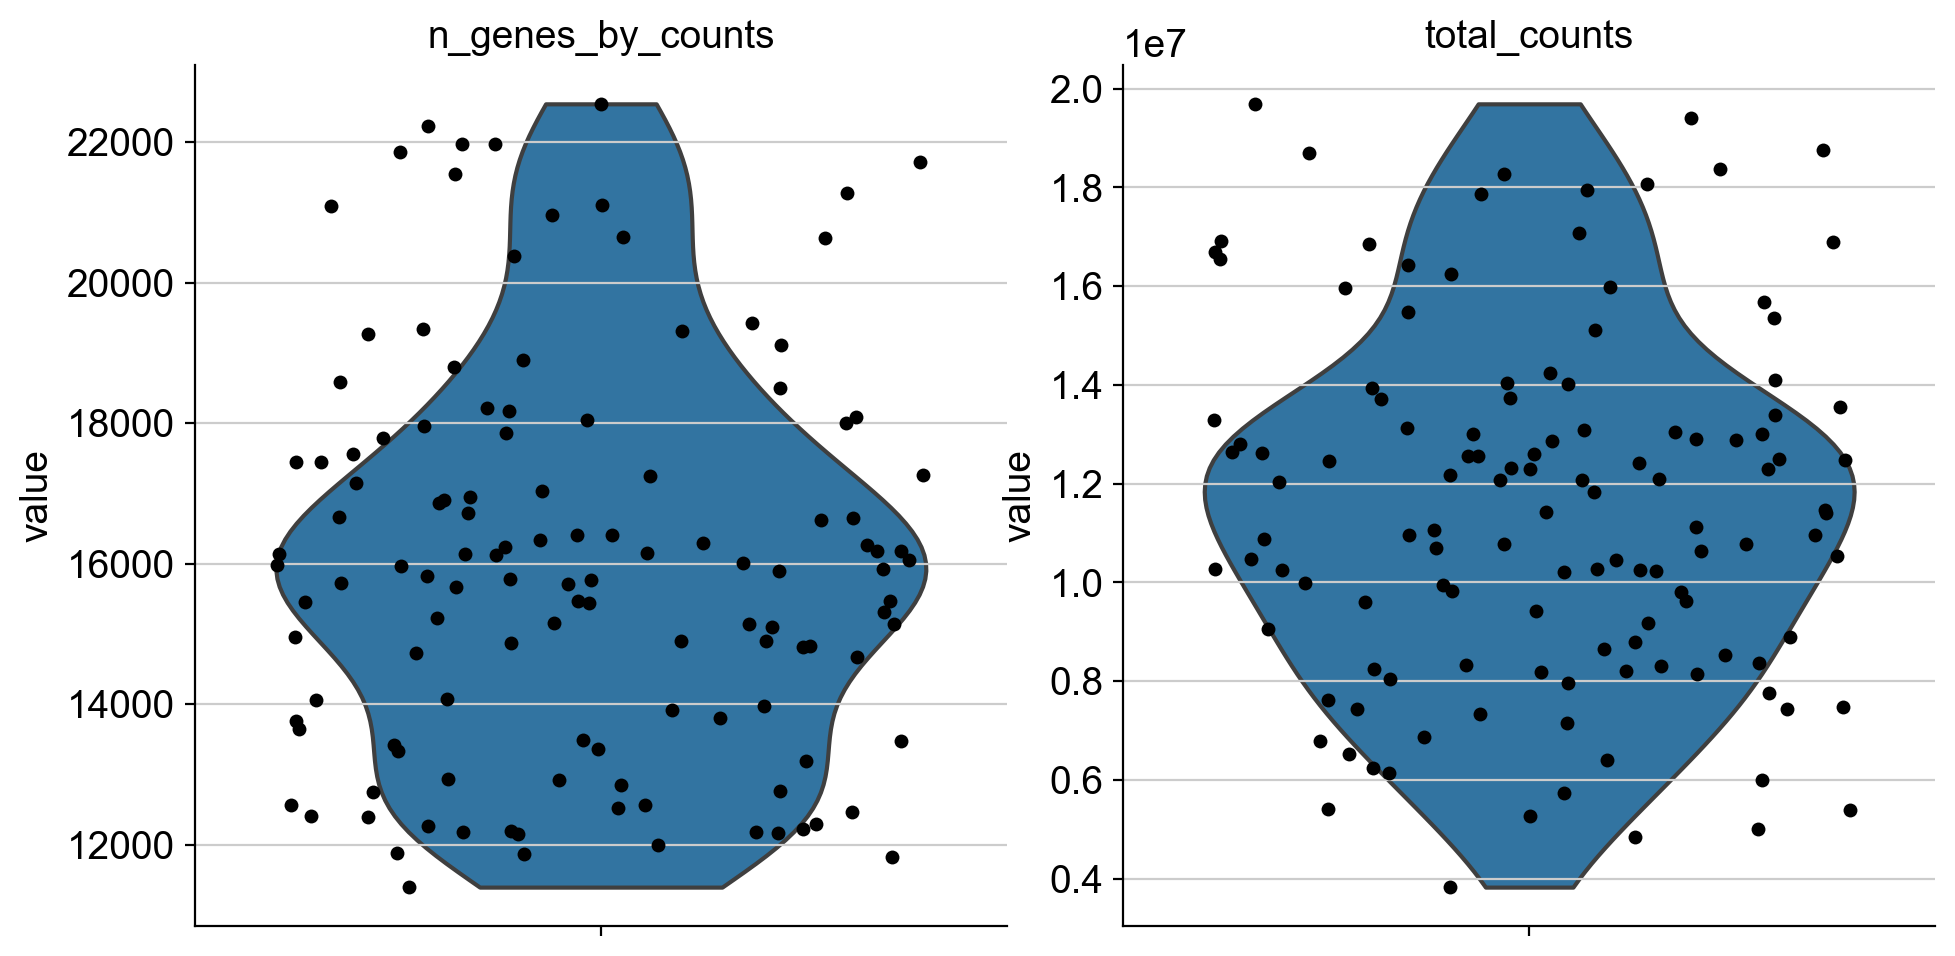

In [128]:
sc.pl.violin(counts_ad, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, size=5)

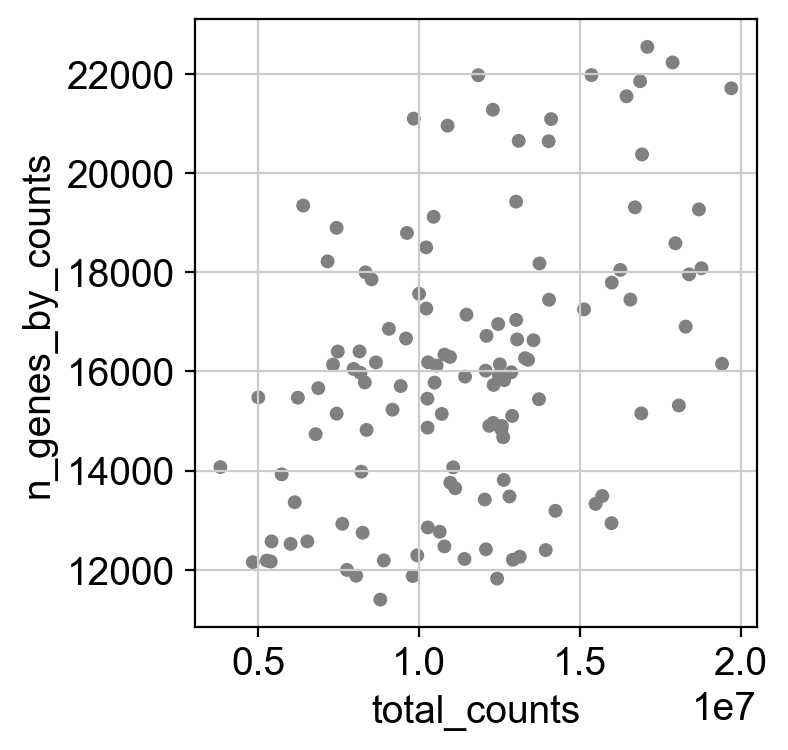

In [129]:
sc.pl.scatter(counts_ad, x='total_counts', y='n_genes_by_counts', size=100)

finding HVGs


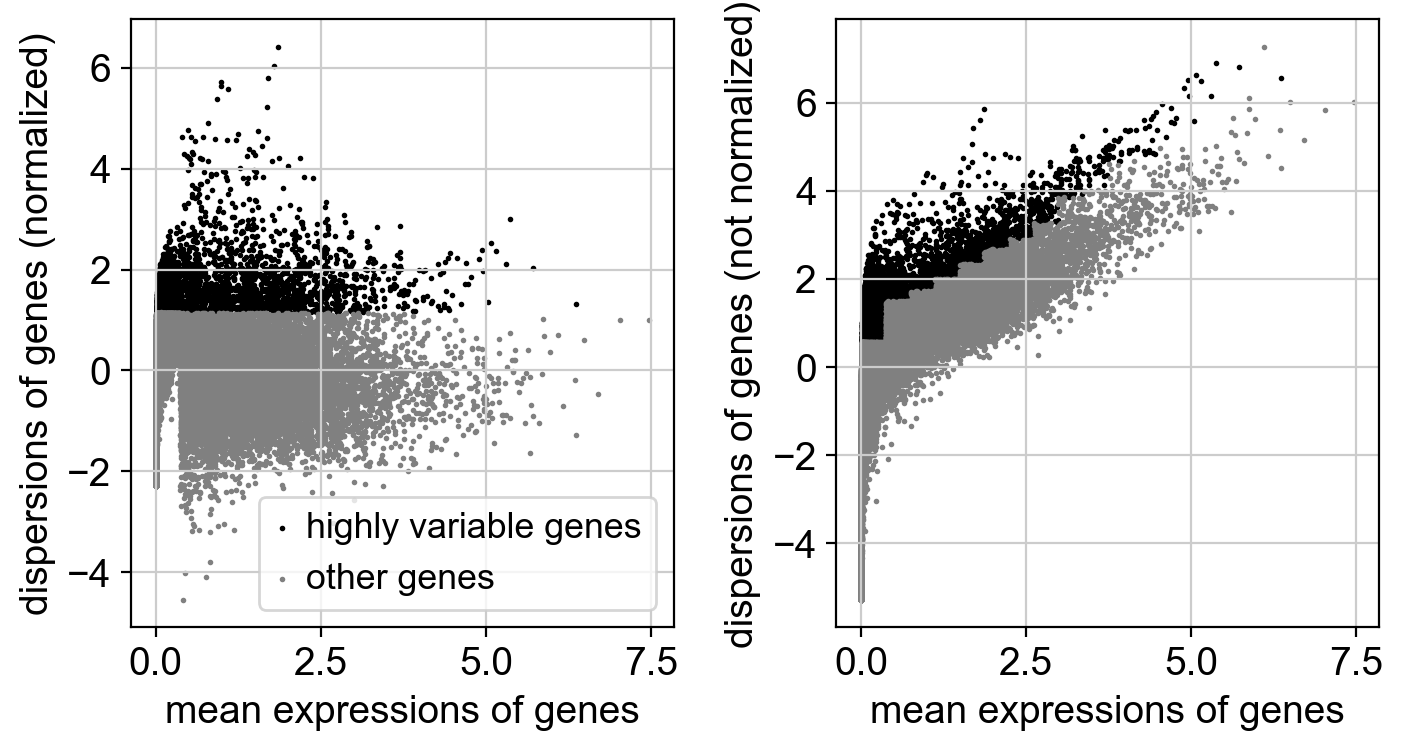

regressing out counts
correcting source effects
Oocyte
2-cell
hESC late
Late blastocyst
Zygote
hESC early
8-cell


/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


4-cell
Morulae


In [130]:
sc.pp.normalize_total(counts_ad, target_sum=10e4)
sc.pp.log1p(counts_ad)

counts_ad.raw = counts_ad

print('finding HVGs')
sc.pp.highly_variable_genes(counts_ad, n_top_genes=4000)
sc.pl.highly_variable_genes(counts_ad)
counts_ad = counts_ad[:, counts_ad.var.highly_variable]

print('regressing out counts')
sc.pp.regress_out(counts_ad, ['total_counts'])

print('correcting source effects')
for cell_stage in list(set(metadata_df.cell_stage)):
    print(cell_stage)
    sc.pp.combat(counts_ad[counts_ad.obs.cell_stage == cell_stage], key='source_name')


/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


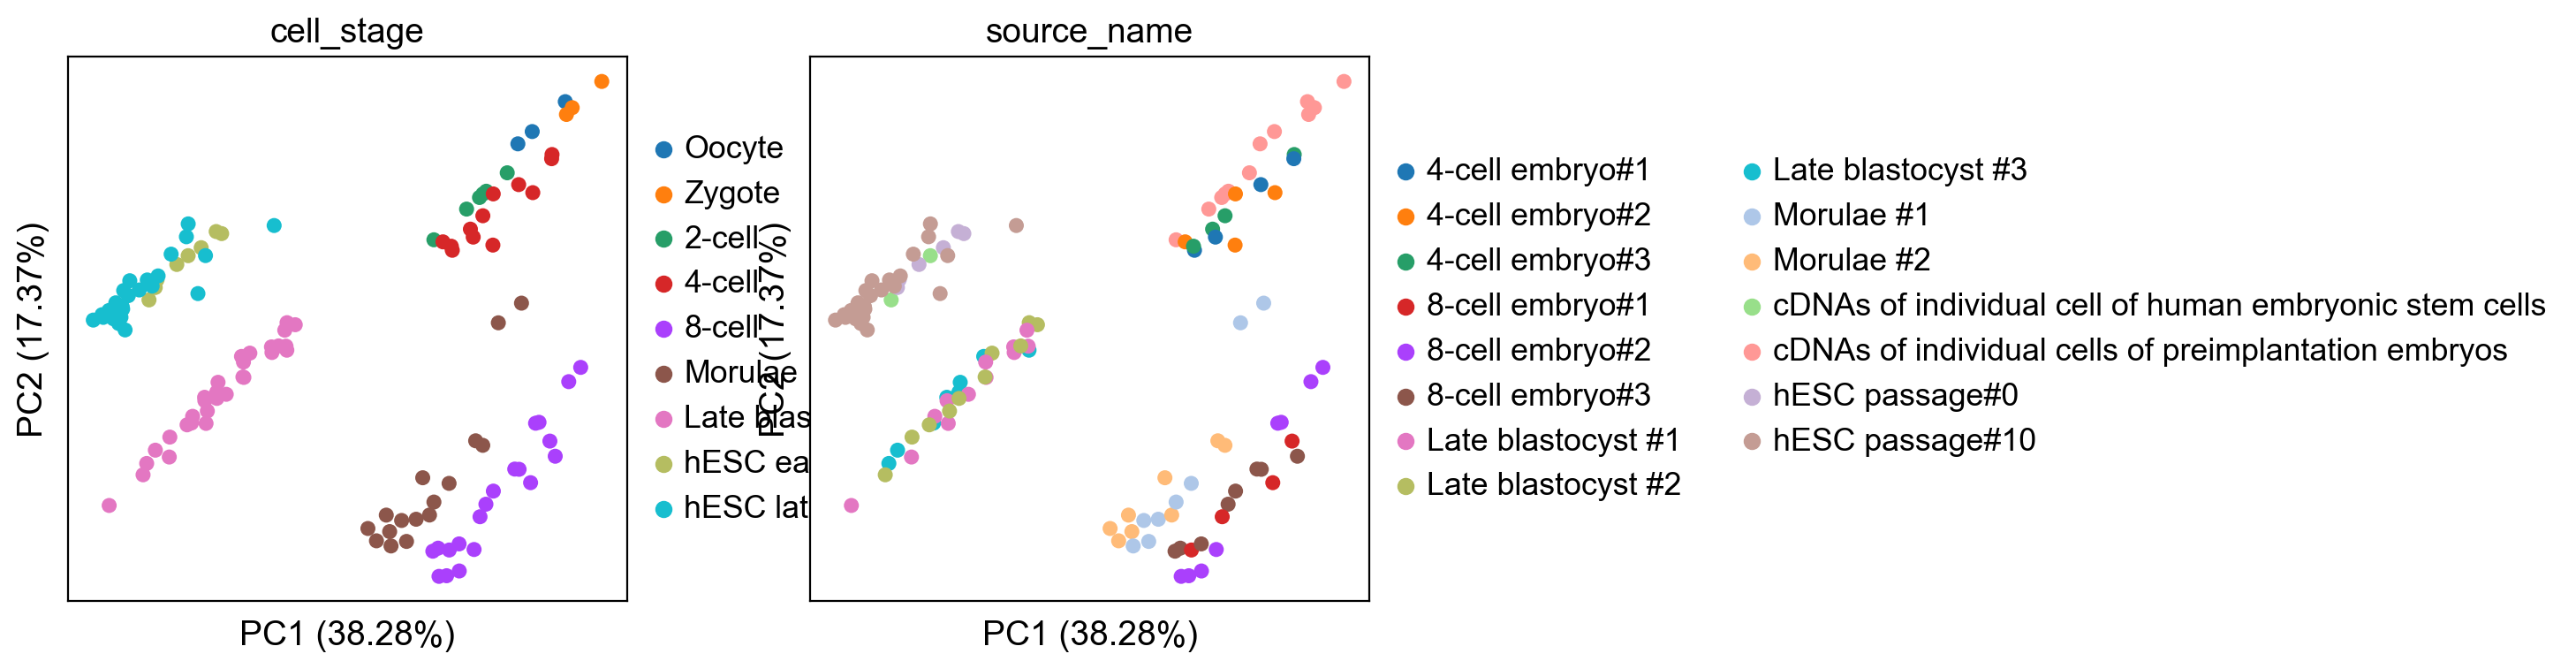

In [131]:
sc.tl.pca(counts_ad, svd_solver='arpack')
sc.pl.pca(counts_ad, size=150, color=['cell_stage', 'source_name'], annotate_var_explained=True, dimensions=[0, 1])

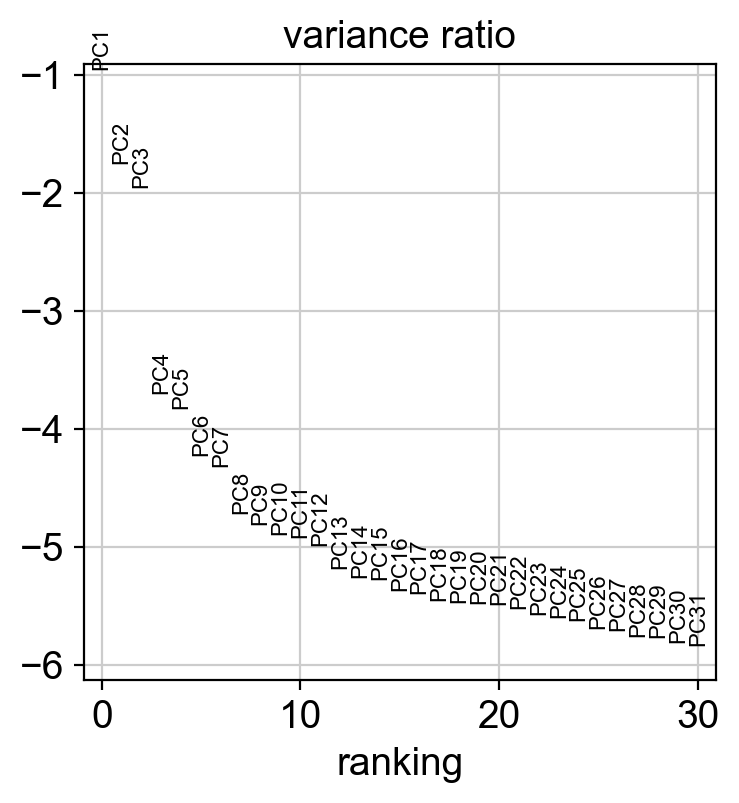

In [137]:
sc.pl.pca_variance_ratio(counts_ad, log=True)

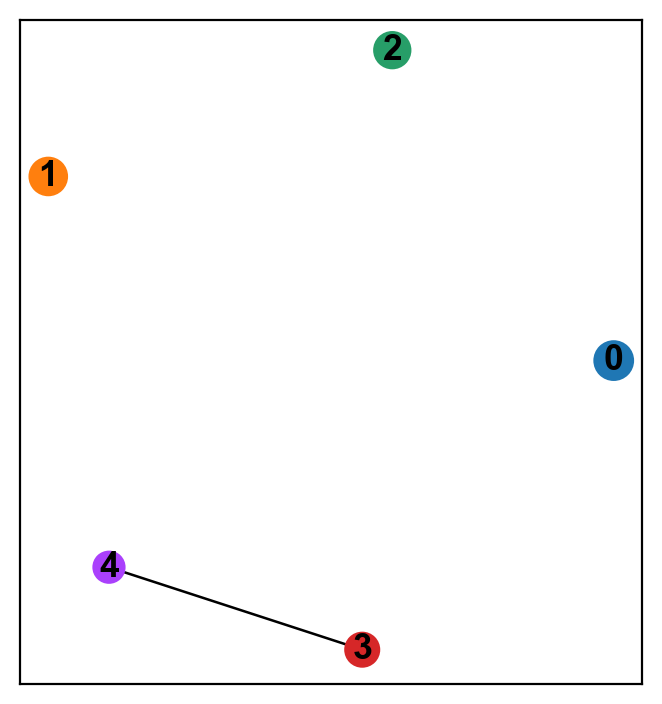

In [133]:
sc.pp.neighbors(counts_ad, n_neighbors=10, n_pcs=30)
sc.tl.louvain(counts_ad)
sc.tl.paga(counts_ad)
sc.pl.paga(counts_ad, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(counts_ad, init_pos='paga')

/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


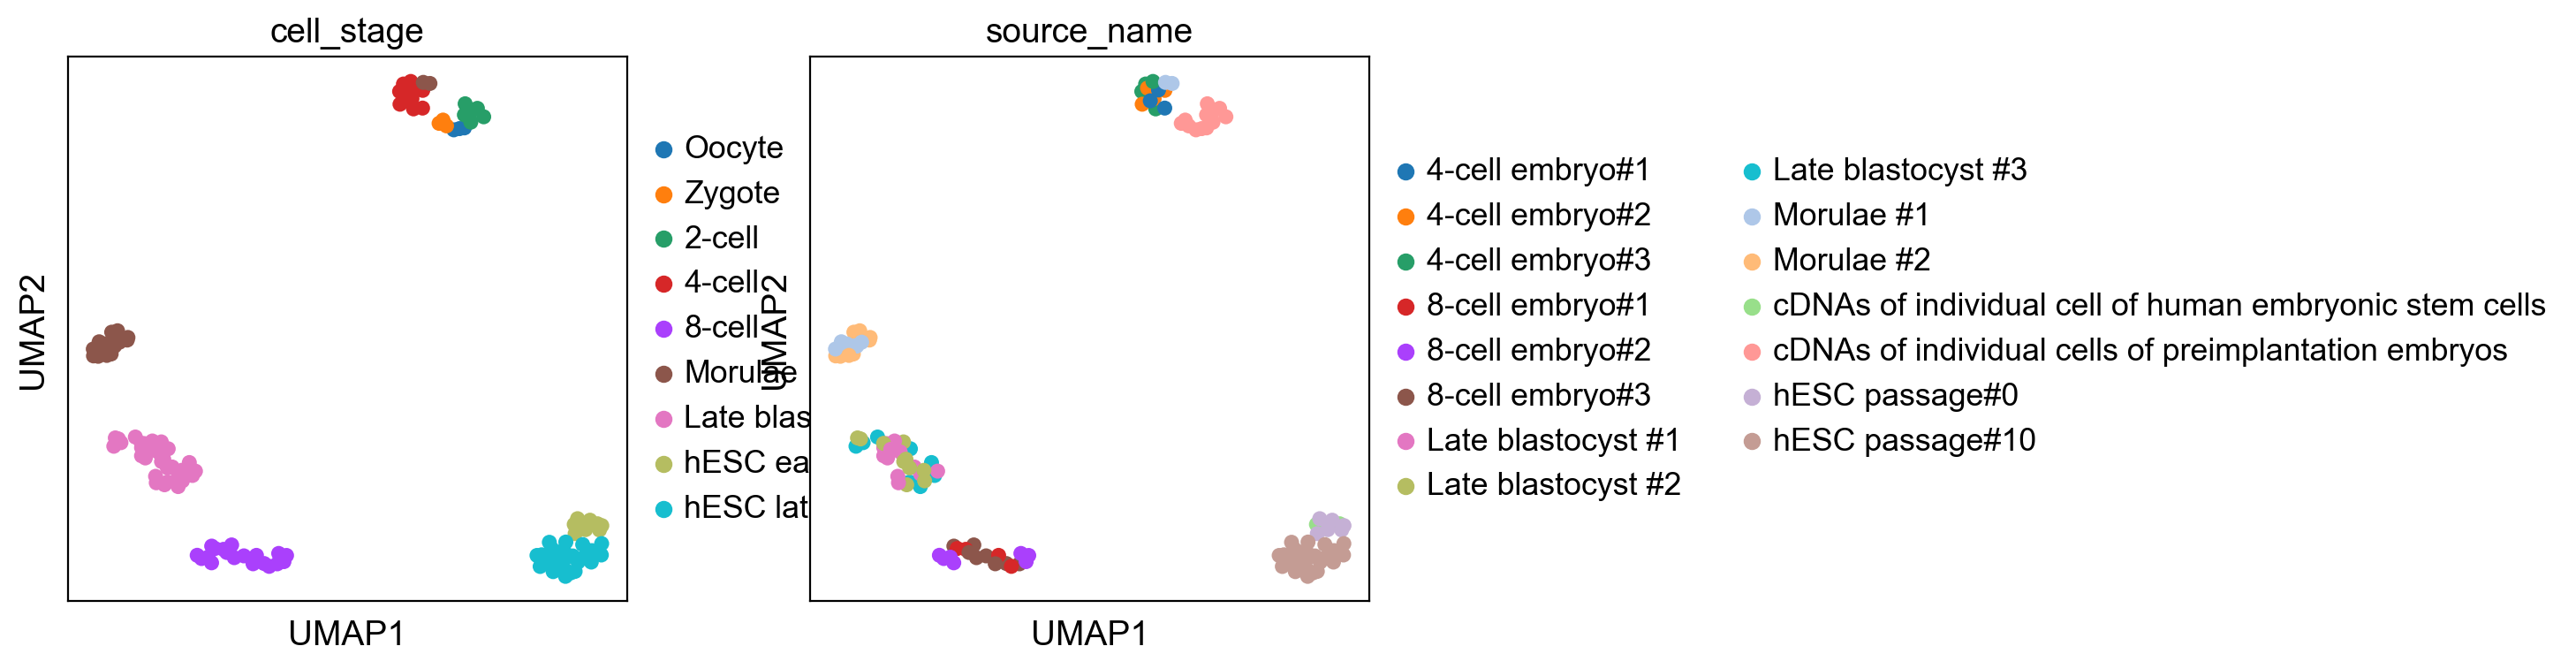

In [134]:
sc.pl.umap(counts_ad, color=['cell_stage', 'source_name'], size=150)

/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


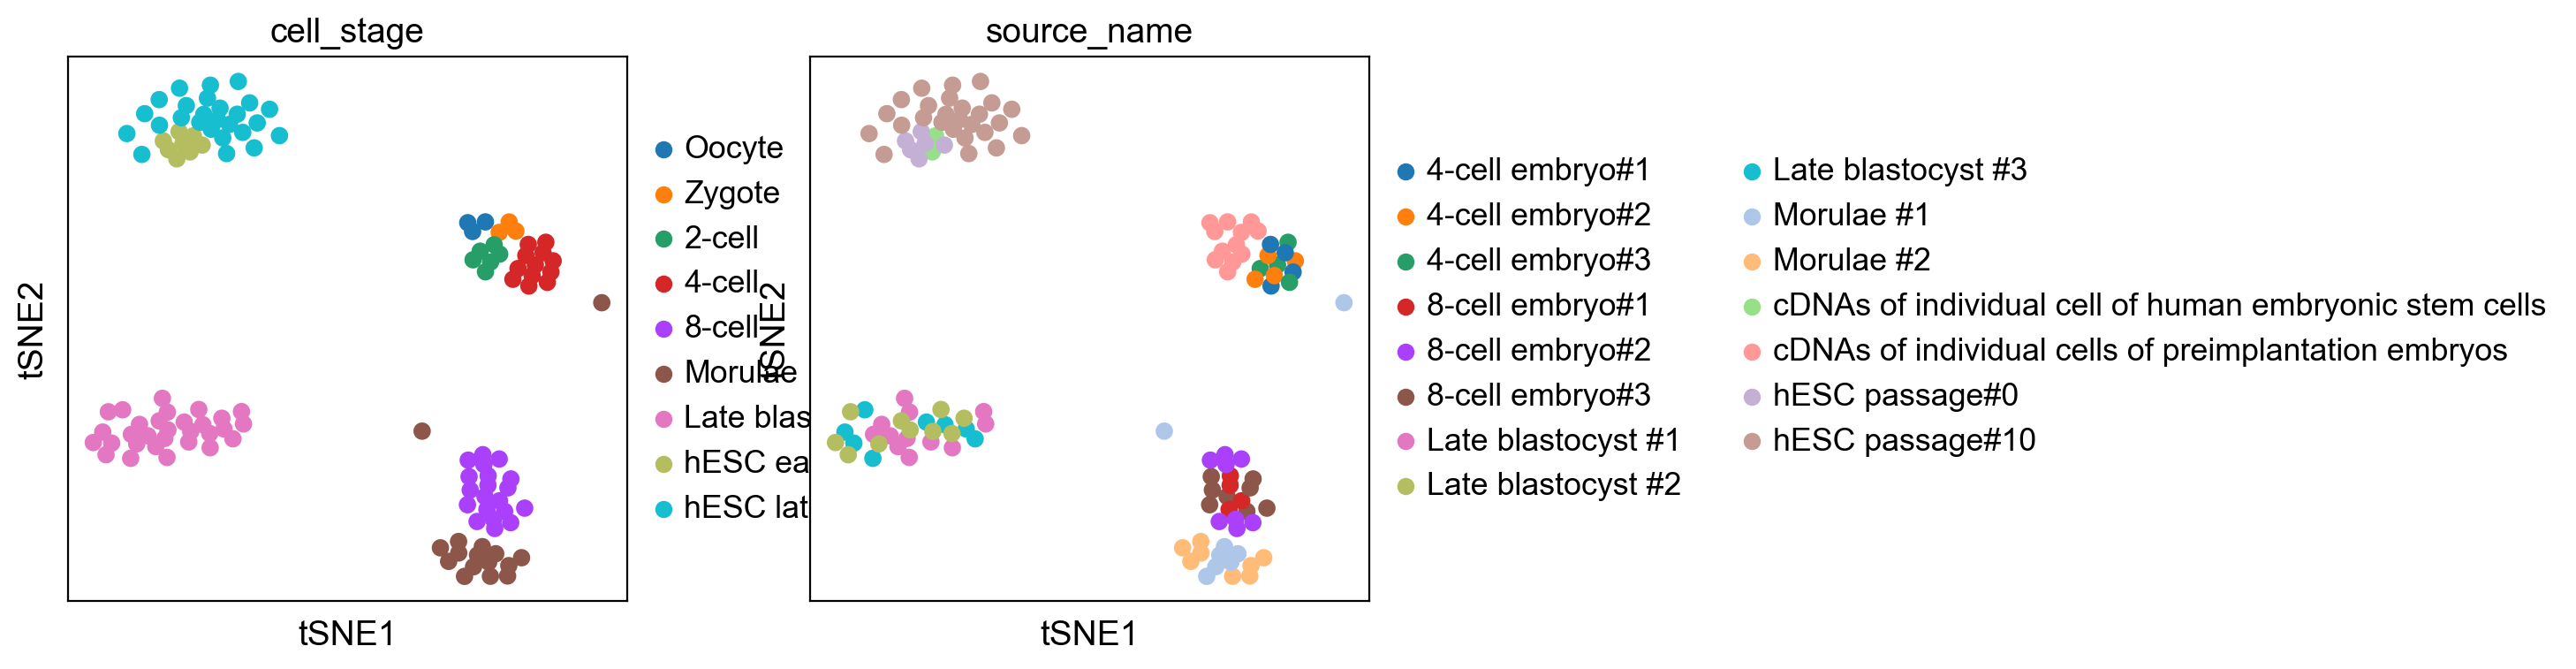

In [141]:
sc.tl.tsne(counts_ad, perplexity=16, early_exaggeration=2)
sc.pl.tsne(counts_ad, size=200, color=['cell_stage', 'source_name'])

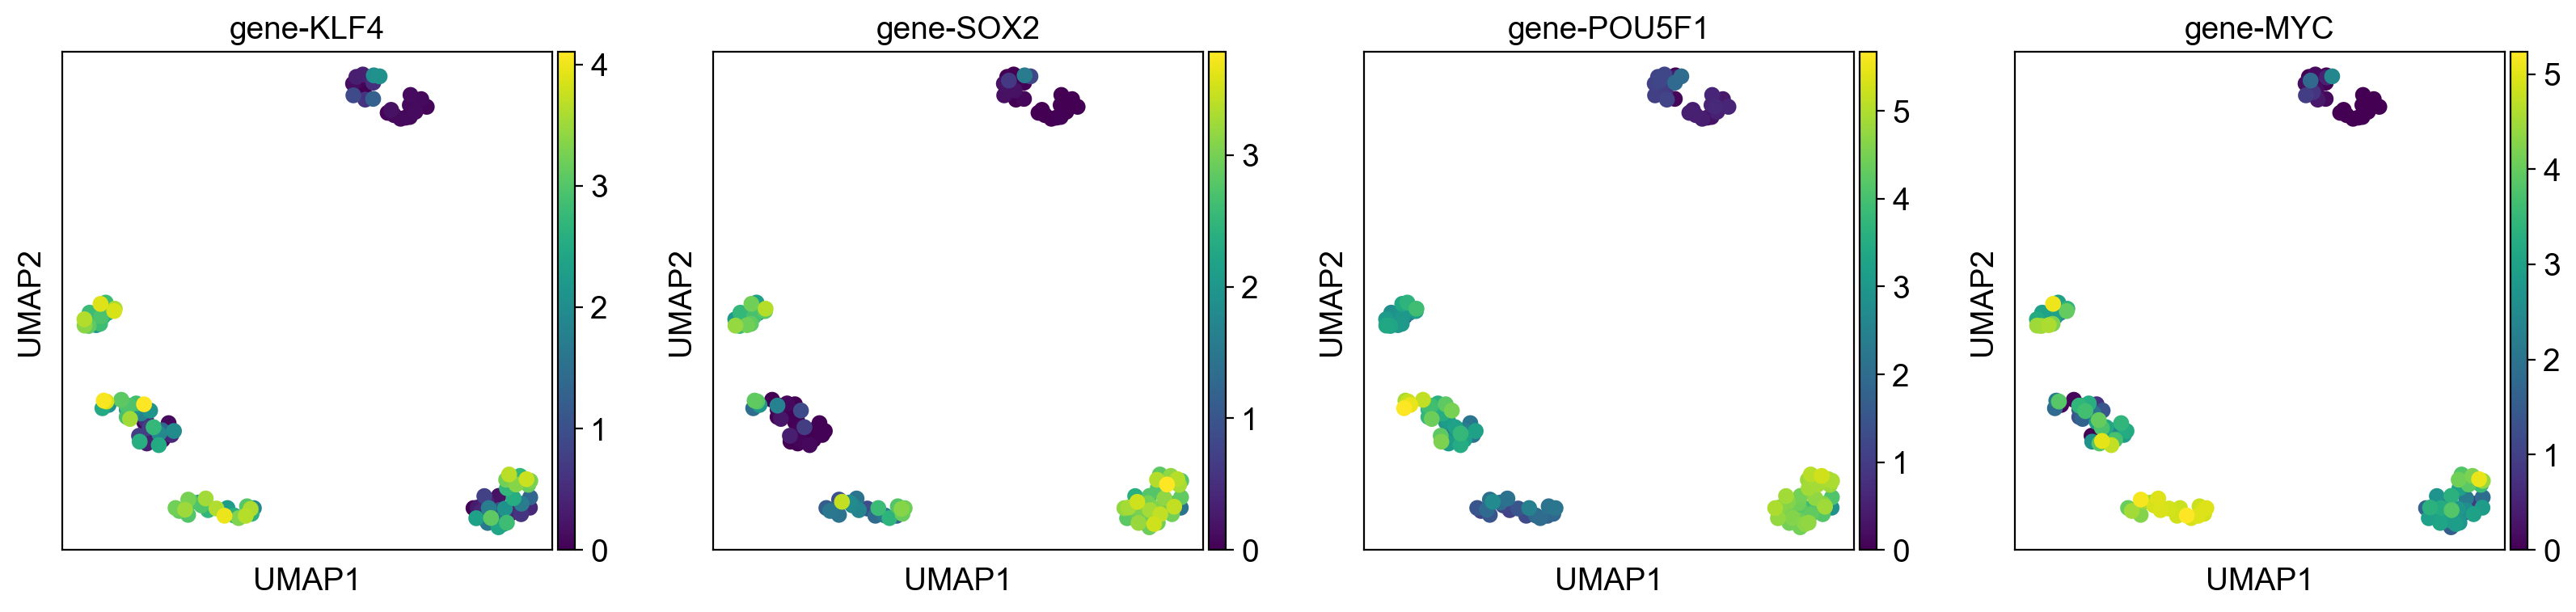

In [136]:
sc.pl.umap(counts_ad, color=['gene-KLF4', 'gene-SOX2', 'gene-POU5F1', 'gene-MYC'], size=200)

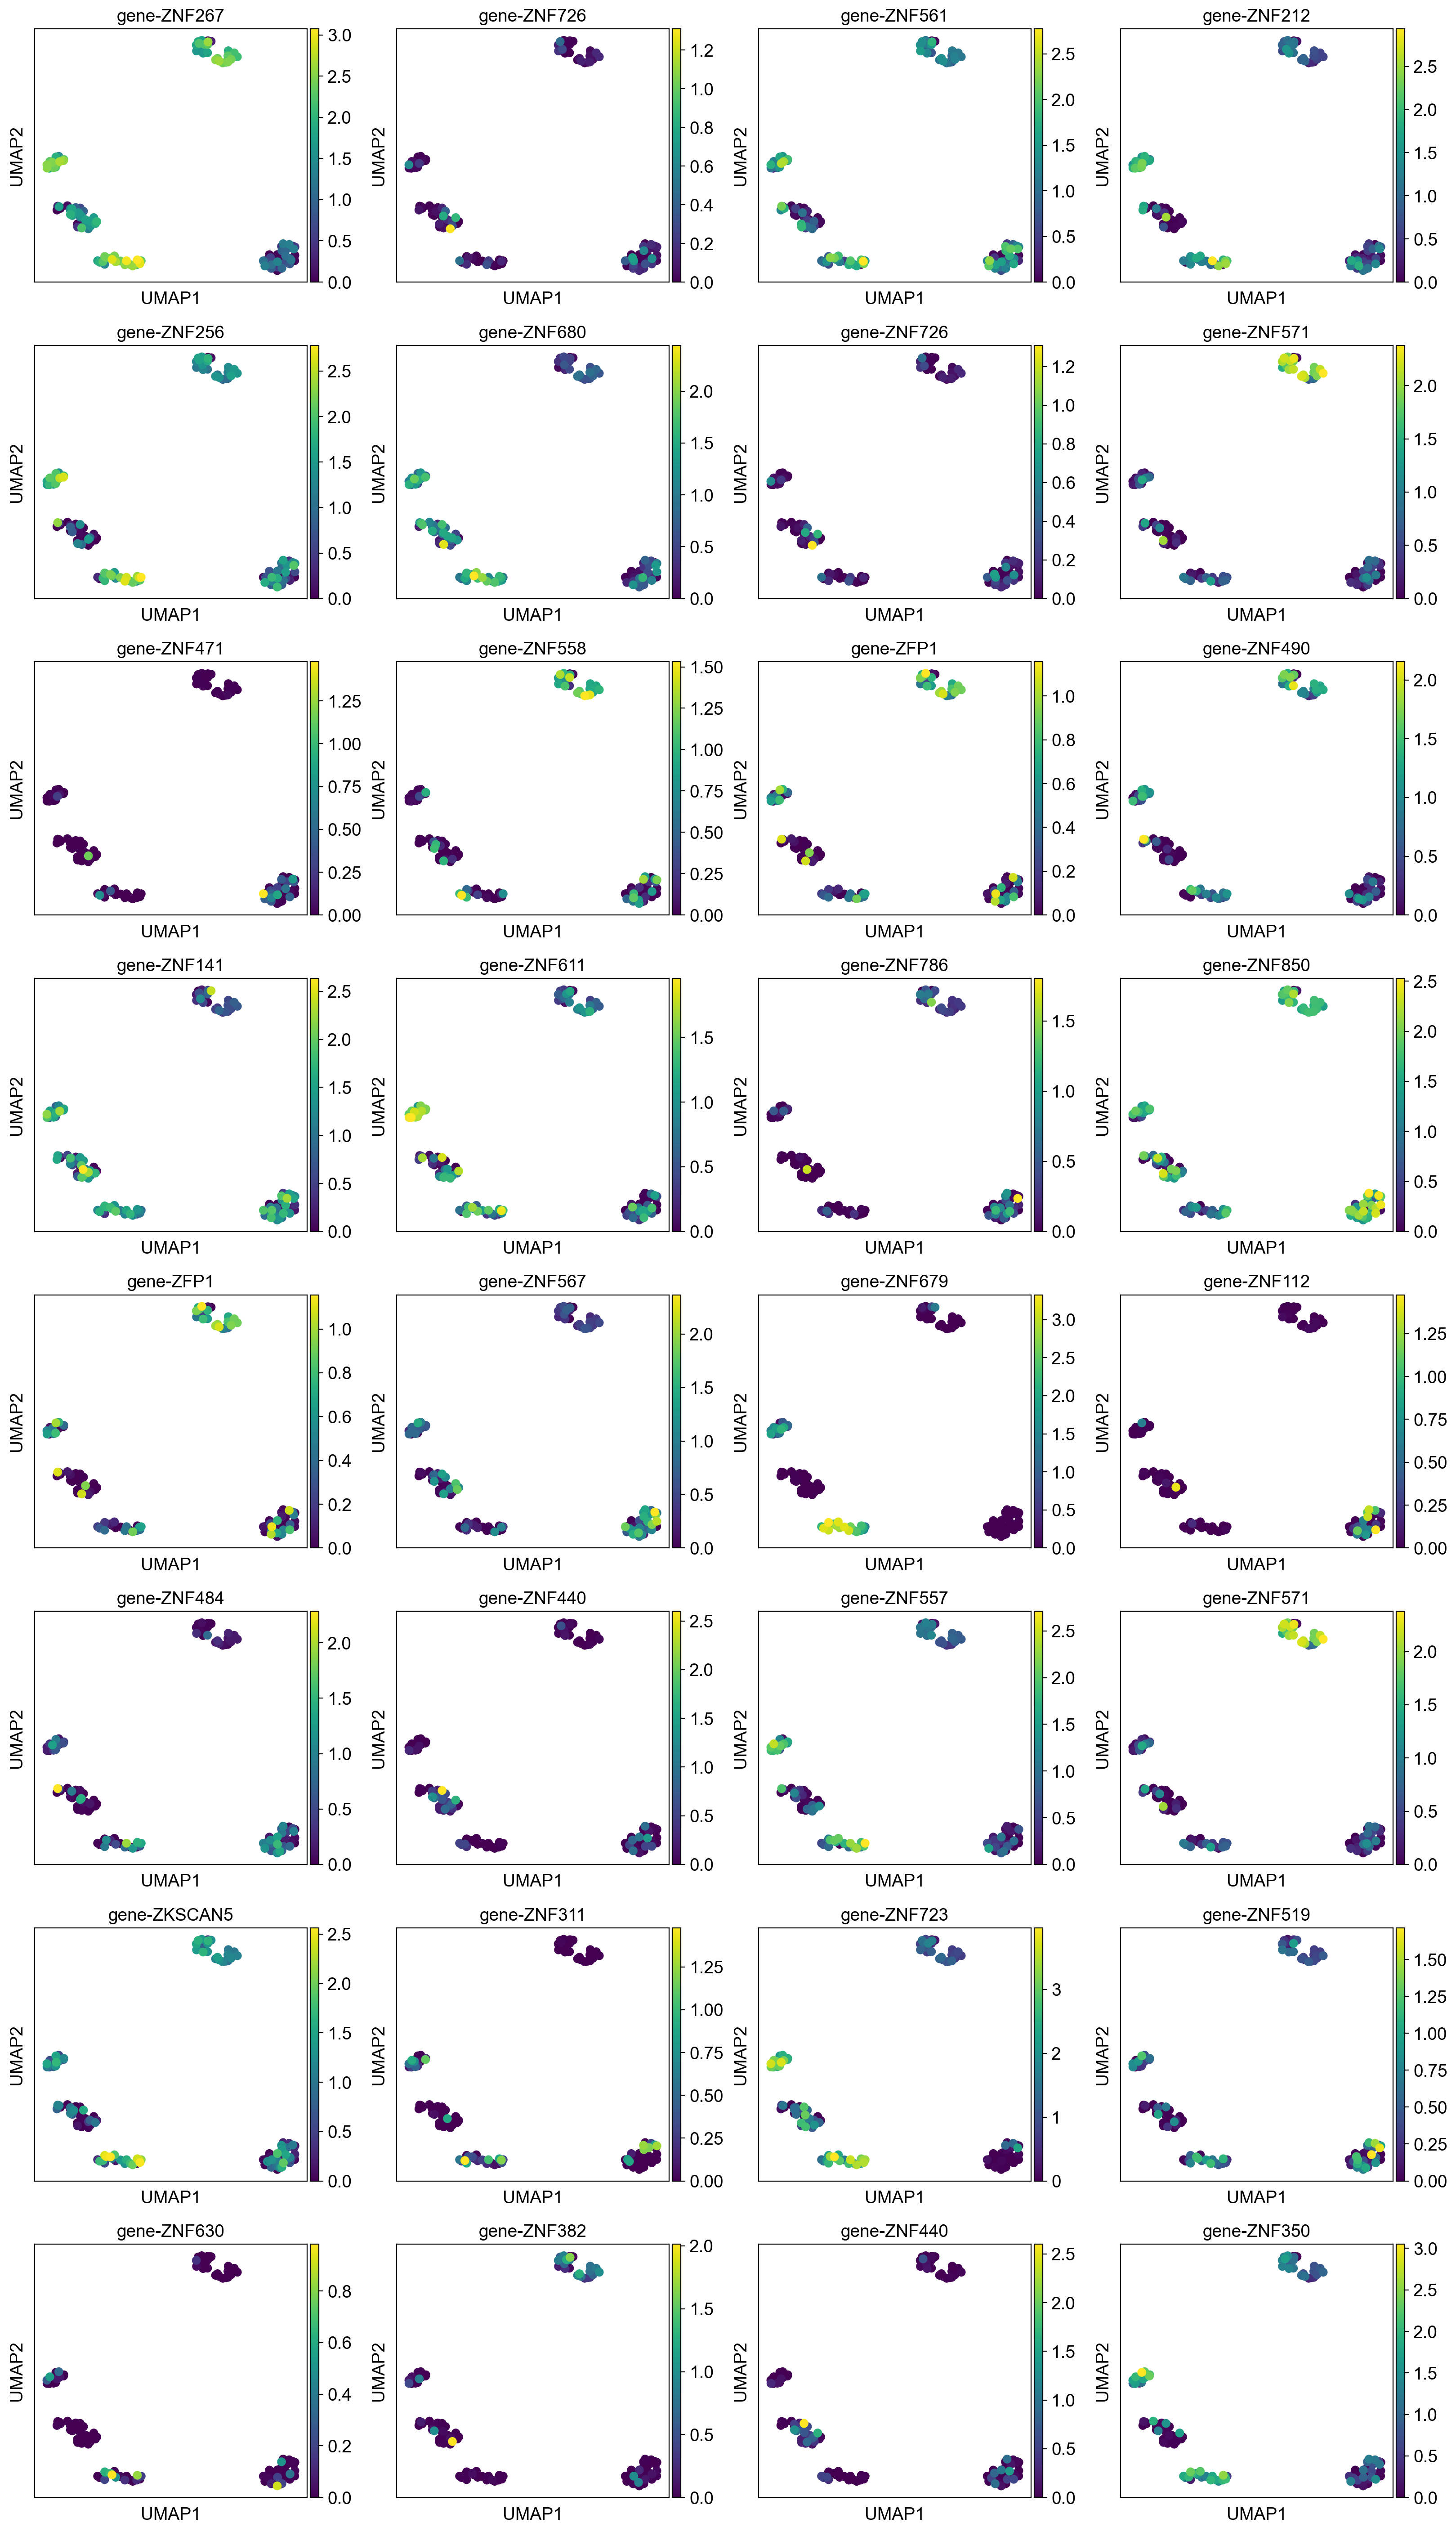

In [149]:
with open('../data/cis-reg/kzfp_list.txt') as infile:
    kzfps = [f'gene-{line.strip()}' for line in infile]
    kzfps = [kzfp for kzfp in kzfps if kzfp in counts_ad.raw.var.index]
sc.pl.umap(counts_ad, color=np.random.choice(kzfps, 32), size=200, cmap='viridis')

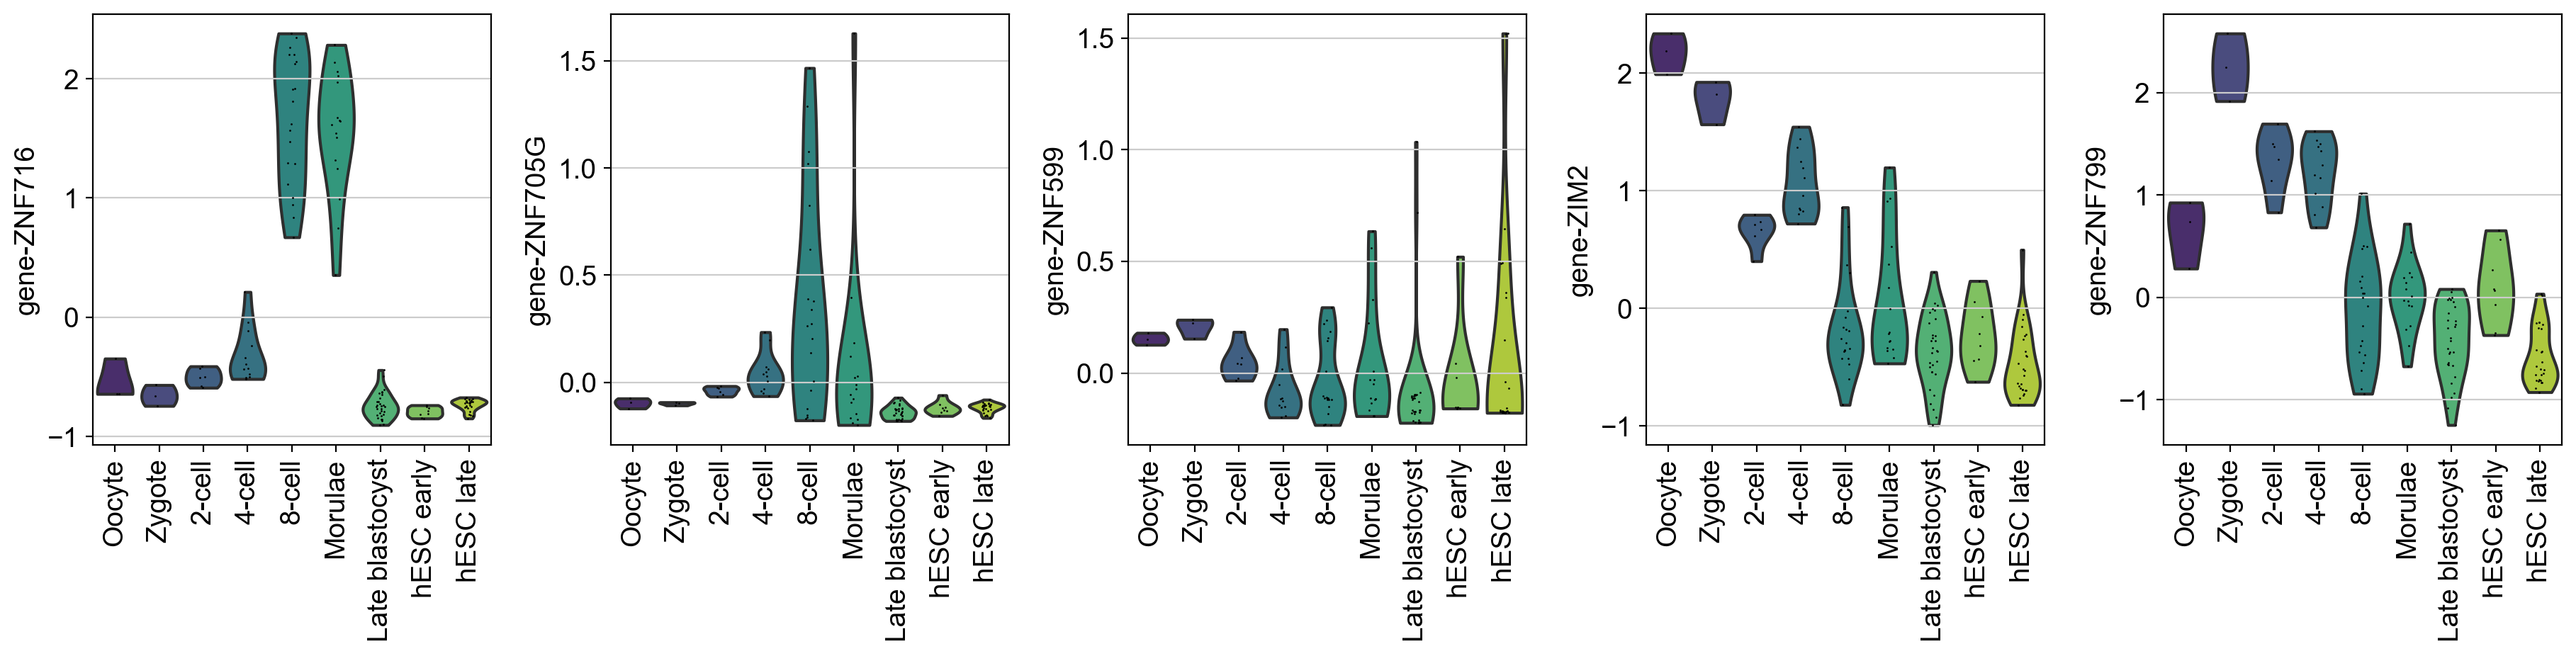

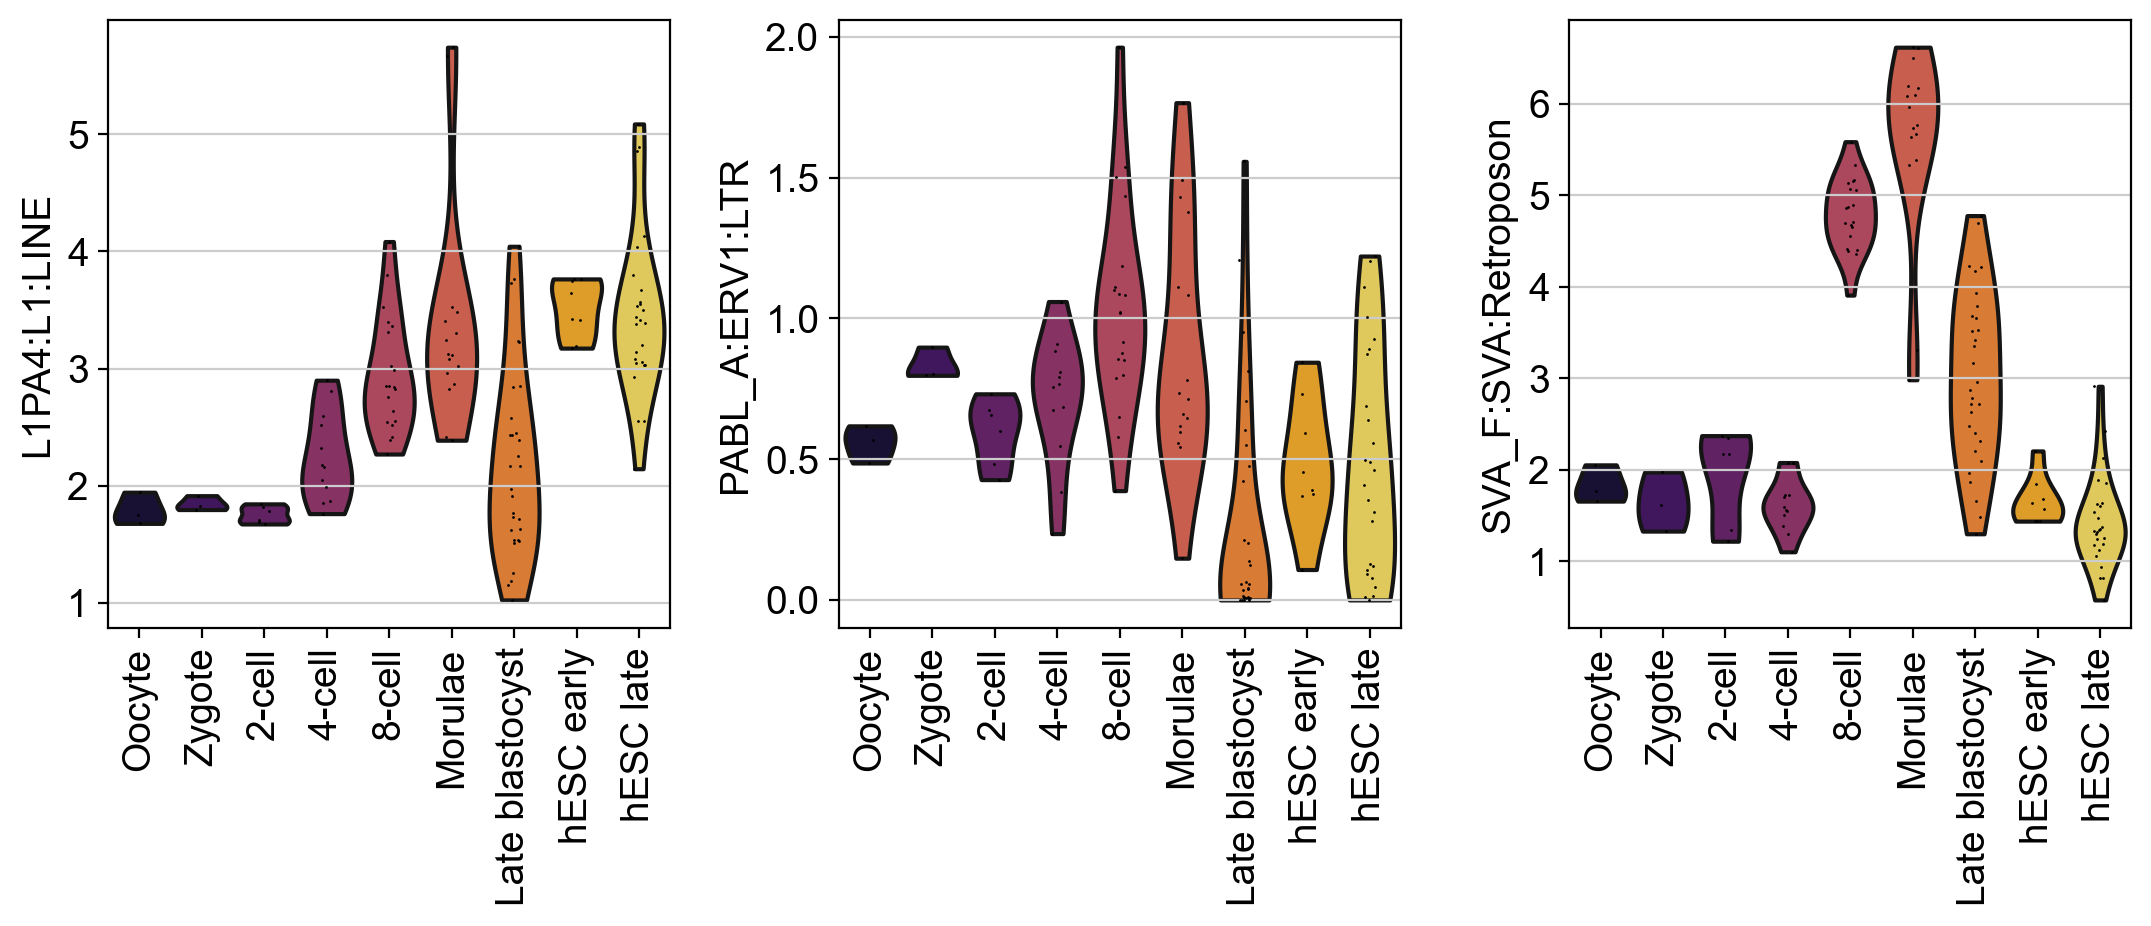

In [143]:
# fig, axes = plt.subplots(figsize=(14, 3), ncols=4)
# axes[3].set_xticklabels(axes[3].get_xticks(), rotation = 50)
# for i, znf in enumerate(['ZNF394', 'ZNF93', 'ZNF90', 'ZNF14']):
#     sc.pl.violin(counts_ad, 
#                  [f'gene-{znf}'], 
#                  groupby='cell_stage', 
#                  ax=axes[i],
#                  order=['Oocyte', 'Zygote', '2-cell', '4-cell', '8-cell', 'Morulae', 'Late blastocyst', 'hESC early', 'hESC', 'hESC late'])
#     plt.show()
sc.pl.violin(counts_ad,
             np.random.choice(kzfps, 6),
             groupby='cell_stage', 
             order=['Oocyte', 'Zygote', '2-cell', '4-cell', '8-cell', 'Morulae', 'Late blastocyst', 'hESC early', 'hESC late'],
             rotation=90,
             palette='viridis',
             save=True,use_raw=False)
sc.pl.violin(counts_ad, 
             ['L1PA4:L1:LINE', 'PABL_A:ERV1:LTR', 'SVA_F:SVA:Retroposon'], 
             groupby='cell_stage', 
             order=['Oocyte', 'Zygote', '2-cell', '4-cell', '8-cell', 'Morulae', 'Late blastocyst', 'hESC early', 'hESC late'],
             rotation=90,
             palette='inferno',
             ncols=2)

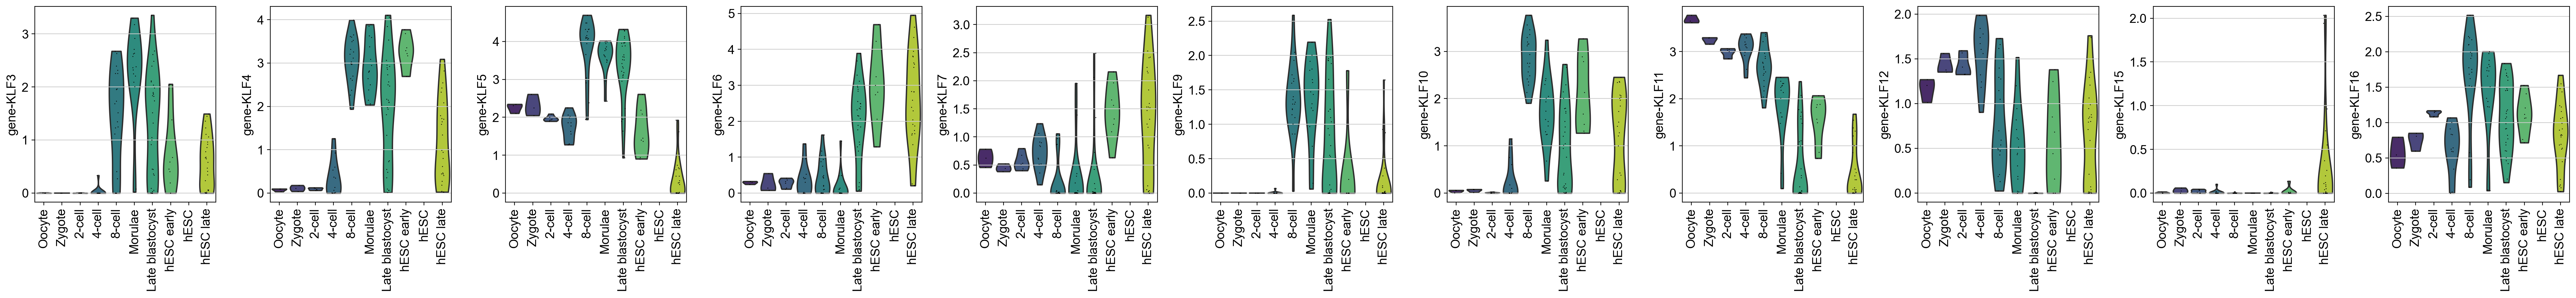

In [114]:
sc.pl.violin(counts_ad, 
             ['gene-KLF3', 'gene-KLF4', 'gene-KLF5', 'gene-KLF6', 'gene-KLF7', 'gene-KLF9', 'gene-KLF10', 'gene-KLF11', 'gene-KLF12', 'gene-KLF15', 'gene-KLF16'], 
             groupby='cell_stage', 
             order=['Oocyte', 'Zygote', '2-cell', '4-cell', '8-cell', 'Morulae', 'Late blastocyst', 'hESC early', 'hESC late'],
             rotation=90,
             palette='viridis')


In [168]:
sc.pl.clustermap(counts_ad, var_names=[k for k in kzfps if k in counts_ad.var_names], groupby=['cell_stage'], swap_axes=True, figsize=(10, 14))

ValueError: Shape of passed values is (124, 44003), indices imply (124, 4000)